In [1]:
"""
The script demonstrates a simple example of using ART with Keras. The example train a small model on the MNIST dataset
and creates adversarial examples using the Fast Gradient Sign Method. Here we use the ART classifier to train the model,
it would also be possible to provide a pretrained model to the ART classifier.
The parameters are chosen for reduced computational requirements of the script and not optimised for accuracy.
"""
# https://stackoverflow.com/questions/42212810/tqdm-in-jupyter-notebook-prints-new-progress-bars-repeatedly
# https://stackoverflow.com/questions/42212810/tqdm-in-jupyter-notebook-prints-new-progress-bars-repeatedly
# replace tqdm imported by any other module with tqdm.notebook
import sys
import tqdm
from tqdm.notebook import tqdm
sys.modules["tqdm"].tqdm = tqdm
sys.modules["tqdm.tqdm"] = tqdm
import ipywidgets as widgets # check if this is installed to make normal tqdm work inside the notebook

import os
import warnings
warnings.filterwarnings('ignore')
import logging
logging.getLogger('tensorflow').setLevel(logging.FATAL)

import keras
from keras.models import Sequential
from keras.layers import Dense, Flatten, Conv2D, MaxPooling2D
import numpy as np

from art.estimators.classification import KerasClassifier

from art.attacks.evasion import SpatialTransformation
from art.attacks.evasion import FastGradientMethod

from art.defences.trainer import AdversarialTrainer

# from art.utils import load_mnist
from art.utils import load_dataset

#this is what makes the plots transparent in notebooks
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sn
# sn.set() #this changes the style of all plots, and imshow shows up wrong
import pandas as pd
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

Using TensorFlow backend.


In [2]:
# Step 1: Load the MNIST dataset
(x_train, y_train), (x_test, y_test), min_pixel_value, max_pixel_value = load_dataset('mnist')
x_train, y_train = x_train[:600], y_train[:600]
x_test, y_test = x_test[:600], y_test[:600]

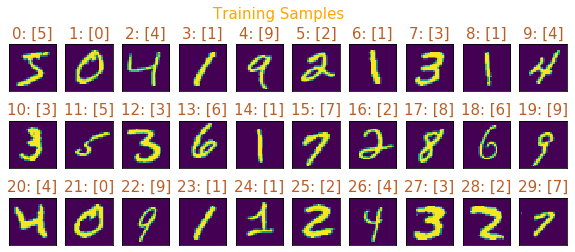

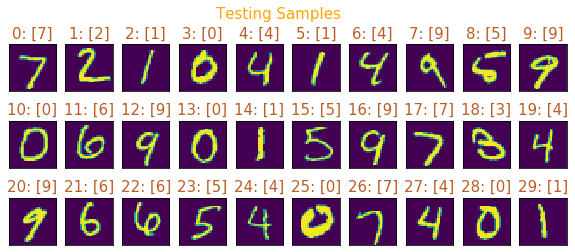

In [3]:
# Step 1.1: Visualize training set and labels
fig, axes = plt.subplots(3,10, figsize=(10,4))
for i,ax in enumerate(axes.flat):
    ax.imshow(x_train[i][:,:,0])
    true_label = np.argwhere(y_train[i] == 1).flatten()
    ax.set_title("{number}: {label}".format(label=true_label, number=i), fontsize=15, color='#ba5e27')
    ax.set_yticklabels([])
    ax.set_xticklabels([])
    ax.tick_params(axis=u'both', which=u'both', length=0)

fig.suptitle('Training Samples', fontsize=15, color='orange')

fig, axes = plt.subplots(3,10, figsize=(10,4))
for i,ax in enumerate(axes.flat):
    ax.imshow(x_test[i][:,:,0])
    true_label = np.argwhere(y_test[i] == 1).flatten()
    ax.set_title("{number}: {label}".format(label=true_label, number=i), fontsize=15, color='#ba5e27')
    ax.set_yticklabels([])
    ax.set_xticklabels([])
    ax.tick_params(axis=u'both', which=u'both', length=0)

fig.suptitle('Testing Samples', fontsize=15, color='orange')

plt.show()

In [4]:
# Step 2: Create the model

model = Sequential()
model.add(Conv2D(filters=4, kernel_size=(5, 5), strides=1, activation="relu", input_shape=(28, 28, 1)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(filters=10, kernel_size=(5, 5), strides=1, activation="relu", input_shape=(23, 23, 4)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(100, activation="relu"))
model.add(Dense(10, activation="softmax"))

model.compile(
    loss=keras.losses.categorical_crossentropy, optimizer=keras.optimizers.Adam(lr=0.01), metrics=["accuracy"]
)

In [5]:
# Step 3: Create the ART classifier

classifier = KerasClassifier(model=model, clip_values=(min_pixel_value, max_pixel_value), use_logits=False)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [6]:
# Step 4: Train the ART classifier

classifier.fit(x_train, y_train, batch_size=64, nb_epochs=3)

all_acc = {}


Epoch 1/3
9/9 [==============================] - ETA: 33s - loss: 2.2993 - acc: 0.09 - 4s 469ms/step - loss: 1.9010 - acc: 0.3993
Epoch 2/3
9/9 [==============================] - ETA: 0s - loss: 0.7125 - acc: 0.890 - 0s 7ms/step - loss: 0.6844 - acc: 0.7795
Epoch 3/3
9/9 [==============================] - ETA: 0s - loss: 0.5048 - acc: 0.843 - 0s 7ms/step - loss: 0.4309 - acc: 0.8733


Accuracy on benign test examples: 81.0%
[0 1 2 3 4 5 6 7 8 9] 10
[0 1 2 3 4 5 6 7 8 9] 10
Accuracy Score : 0.81
Report : 
              precision    recall  f1-score   support

           0       0.88      0.98      0.93        53
           1       0.92      0.97      0.95        73
           2       0.76      0.94      0.84        64
           3       0.77      0.85      0.81        62
           4       0.74      0.82      0.78        67
           5       0.92      0.59      0.72        56
           6       0.94      0.62      0.74        52
           7       0.76      0.79      0.78        57
           8       0.82      0.69      0.75        52
           9       0.71      0.77      0.74        64

    accuracy                           0.81       600
   macro avg       0.82      0.80      0.80       600
weighted avg       0.82      0.81      0.81       600



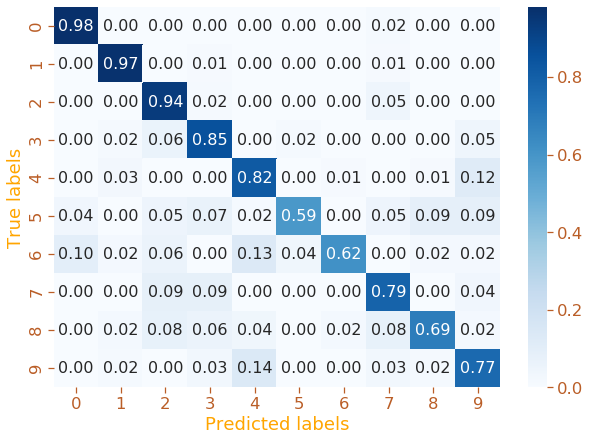

In [7]:
# Step 5: Evaluate the ART classifier on benign test examples
predictions = classifier.predict(x_test)
accuracy = np.sum(np.argmax(predictions, axis=1) == np.argmax(y_test, axis=1)) / len(y_test)
print("Accuracy on benign test examples: {}%".format(accuracy * 100))
all_acc['nat'] = accuracy * 100

y_true = np.argmax(y_test, axis=1)
y_pred = np.argmax(predictions, axis=1)
cm = confusion_matrix(y_true, y_pred)

fmt = '.2g'
# Normalize
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]; fmt = '.2f'

print(np.unique(y_true), len(np.unique(y_true)))
print(np.unique(y_pred), len(np.unique(y_pred)))

print('Accuracy Score :', accuracy_score(y_true, y_pred))
print('Report : ')
print(classification_report(y_true, y_pred))

df_cm = pd.DataFrame(cm, range(cm.shape[0]), range(cm.shape[0]))
plt.figure(figsize=(10,7))

with sn.plotting_context(context="notebook", font_scale=1.5), \
plt.rc_context({'axes.labelcolor':'orange', 'xtick.color':'#ba5e27', 'ytick.color':'#ba5e27'}):
    sn.heatmap(df_cm, annot=True, cmap='Blues', fmt=fmt, annot_kws={"size": 16}) #cmap: inferno; Blues

plt.xlabel('Predicted labels');
plt.ylabel('True labels');

plt.show()

In [8]:
# Step 6: Generate adversarial test examples

# Craft adversarial samples
print("Create adversarial attack")
attack = SpatialTransformation(classifier=classifier, max_translation=10.0, num_translations=1, max_rotation=30.0, num_rotations=1)
# attack = FastGradientMethod(classifier, eps=0.1)
print("Craft attack on training examples")
x_train_adv = attack.generate(x_train)
print("Craft attack test examples")
x_test_adv = attack.generate(x_test)

print(x_train_adv.shape)
print(x_test_adv.shape)

Create adversarial attack
Craft attack on training examples




Craft attack test examples
(600, 28, 28, 1)
(600, 28, 28, 1)


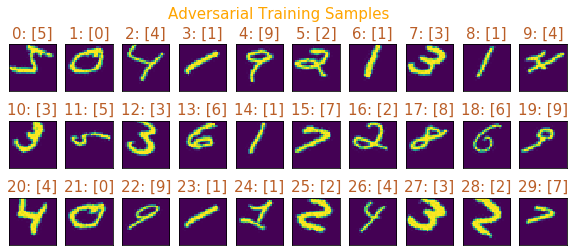

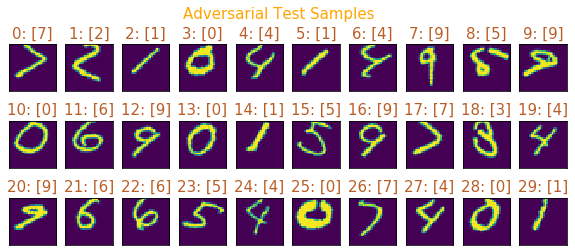

In [9]:
# Step 6.1: Visualize adversarial samples
fig, axes = plt.subplots(3,10, figsize=(10,4), facecolor='None')
for i,ax in enumerate(axes.flat):
    ax.imshow(x_train_adv[i][:,:,0])
    true_label = np.argwhere(y_train[i] == 1).flatten()
    ax.set_title("{number}: {label}".format(label=true_label, number=i), fontsize=15, color='#ba5e27')
    ax.set_yticklabels([])
    ax.set_xticklabels([])
    ax.tick_params(axis=u'both', which=u'both', length=0)

fig.suptitle('Adversarial Training Samples', fontsize=15, color='orange')

fig, axes = plt.subplots(3,10, figsize=(10,4))
for i,ax in enumerate(axes.flat):
    ax.imshow(x_test_adv[i][:,:,0])
    true_label = np.argwhere(y_test[i] == 1).flatten()
    ax.set_title("{number}: {label}".format(label=true_label, number=i), fontsize=15, color='#ba5e27')
    ax.set_yticklabels([])
    ax.set_xticklabels([])
    ax.tick_params(axis=u'both', which=u'both', length=0)

fig.suptitle('Adversarial Test Samples', fontsize=15, color='orange')

plt.show()

In [10]:
# classifier.save("model.h5", path=".")

Accuracy on adversarial test examples before AT: 5.666666666666666%
[0 1 2 3 4 5 6 7 8 9] 10
[0 1 2 3 4 5 6 7 8 9] 10
Accuracy Score : 0.056666666666666664
Report : 
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        53
           1       0.28      0.23      0.25        73
           2       0.01      0.03      0.02        64
           3       0.00      0.00      0.00        62
           4       0.06      0.12      0.08        67
           5       0.00      0.00      0.00        56
           6       0.33      0.02      0.04        52
           7       0.05      0.04      0.04        57
           8       0.13      0.08      0.10        52
           9       0.00      0.00      0.00        64

    accuracy                           0.06       600
   macro avg       0.09      0.05      0.05       600
weighted avg       0.09      0.06      0.06       600



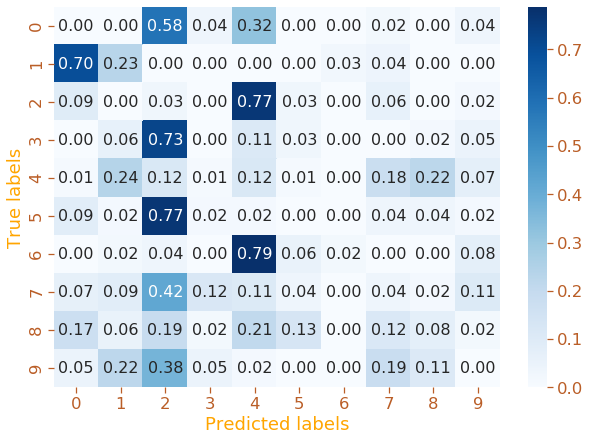

In [11]:
# Step 7: Evaluate the ART classifier on adversarial test examples

predictions = classifier.predict(x_test_adv)
accuracy = np.sum(np.argmax(predictions, axis=1) == np.argmax(y_test, axis=1)) / len(y_test)
print("Accuracy on adversarial test examples before AT: {}%".format(accuracy * 100))
all_acc['adv_before_AT'] = accuracy * 100

y_true = np.argmax(y_test, axis=1)
y_pred = np.argmax(predictions, axis=1)
cm = confusion_matrix(y_true, y_pred)

fmt = '.2g'
# Normalize
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]; fmt = '.2f'

print(np.unique(y_true), len(np.unique(y_true)))
print(np.unique(y_pred), len(np.unique(y_pred)))

print('Accuracy Score :', accuracy_score(y_true, y_pred))
print('Report : ')
print(classification_report(y_true, y_pred))

df_cm = pd.DataFrame(cm, range(cm.shape[0]), range(cm.shape[0]))
plt.figure(figsize=(10,7), facecolor='None')
with sn.plotting_context(context="notebook", font_scale=1.5), \
plt.rc_context({'axes.labelcolor':'orange', 'xtick.color':'#ba5e27', 'ytick.color':'#ba5e27'}):
    sn.heatmap(df_cm, annot=True, cmap='Blues', fmt=fmt, annot_kws={"size": 16}) #cmap: inferno; Blues
plt.xlabel('Predicted labels');
plt.ylabel('True labels');

plt.show()

In [12]:
# Step 8: Create adversarial trainer and perform adversarial training
adv_trainer = AdversarialTrainer(classifier, attacks=attack, ratio=1.0)
adv_trainer.fit(x_train_adv, y_train, batch_size=64, nb_epochs=3)

Adversarial training epochs: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.28s/it]


In [13]:
# Step 9: Evaluate new robustly trained classifier
predictions = classifier.predict(x_test_adv)
accuracy = np.sum(np.argmax(predictions, axis=1) == np.argmax(y_test, axis=1)) / len(y_test)
print("Accuracy on adversarial test examples after AT: {}%".format(accuracy * 100))
all_acc['adv_after_AT'] = accuracy * 100

print(all_acc)

Accuracy on adversarial test examples after AT: 11.833333333333334%
{'nat': 81.0, 'adv_before_AT': 5.666666666666666, 'adv_after_AT': 11.833333333333334}


[0 1 2 3 4 5 6 7 8 9] 10
[0 1 2 3 4 5 6 7 9] 9
Accuracy Score : 0.11833333333333333
Report : 
              precision    recall  f1-score   support

           0       0.46      0.51      0.48        53
           1       0.14      0.27      0.18        73
           2       0.07      0.17      0.10        64
           3       0.00      0.00      0.00        62
           4       0.00      0.00      0.00        67
           5       0.31      0.07      0.12        56
           6       0.22      0.04      0.07        52
           7       0.00      0.00      0.00        57
           8       0.00      0.00      0.00        52
           9       0.05      0.11      0.07        64

    accuracy                           0.12       600
   macro avg       0.12      0.12      0.10       600
weighted avg       0.12      0.12      0.10       600



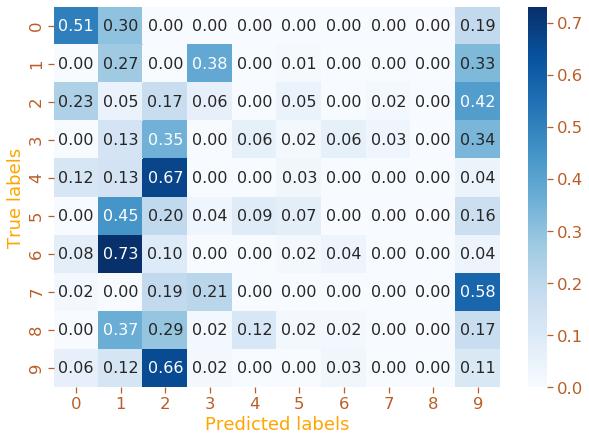

[('axes.edgecolor', 'black'),
 ('axes.facecolor', 'white'),
 ('axes.labelcolor', 'black'),
 ('boxplot.boxprops.color', 'black'),
 ('boxplot.capprops.color', 'black'),
 ('boxplot.flierprops.color', 'black'),
 ('boxplot.flierprops.markeredgecolor', 'black'),
 ('boxplot.flierprops.markerfacecolor', 'none'),
 ('boxplot.meanprops.color', 'C2'),
 ('boxplot.meanprops.markeredgecolor', 'C2'),
 ('boxplot.meanprops.markerfacecolor', 'C2'),
 ('boxplot.medianprops.color', 'C1'),
 ('boxplot.whiskerprops.color', 'black'),
 ('figure.edgecolor', (1, 1, 1, 0)),
 ('figure.facecolor', (1, 1, 1, 0)),
 ('grid.color', '#b0b0b0'),
 ('hatch.color', 'black'),
 ('legend.edgecolor', '0.8'),
 ('legend.facecolor', 'inherit'),
 ('lines.color', 'C0'),
 ('lines.markeredgecolor', 'auto'),
 ('lines.markerfacecolor', 'auto'),
 ('patch.edgecolor', 'black'),
 ('patch.facecolor', 'C0'),
 ('patch.force_edgecolor', False),
 ('pdf.inheritcolor', False),
 ('savefig.edgecolor', 'white'),
 ('savefig.facecolor', 'white'),
 ('scat

In [14]:
y_true = np.argmax(y_test, axis=1)
y_pred = np.argmax(predictions, axis=1)
cm = confusion_matrix(y_true, y_pred)

fmt = '.2g'
# Normalize
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]; fmt = '.2f'

print(np.unique(y_true), len(np.unique(y_true)))
print(np.unique(y_pred), len(np.unique(y_pred)))

print('Accuracy Score :', accuracy_score(y_true, y_pred))
print('Report : ')
print(classification_report(y_true, y_pred))
# %matplotlib inline
df_cm = pd.DataFrame(cm, range(cm.shape[0]), range(cm.shape[0]))

plt.figure(figsize=(10,7), facecolor='None')
# print(plt.style.available)
# plt.style.use('default')
with sn.plotting_context(context="notebook", font_scale=1.5), \
plt.rc_context({'axes.labelcolor':'orange', 'xtick.color':'#ba5e27', 'ytick.color':'#ba5e27'}):
    hm = sn.heatmap(df_cm, annot=True, cmap='Blues', fmt=fmt, annot_kws={"size": 16}) #cmap: inferno; Blues
plt.xlabel('Predicted labels');
plt.ylabel('True labels');

plt.show()
# dir(hm)
[(param, value) for param, value in plt.rcParams.items() if 'color' in param]